# Compilation of all feature data for the model

In [87]:
import pandas as pd    
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point
import numpy as np
import shapely
from shapely import speedups
speedups.enabled
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})

## Zipcode boundary download

In [2]:
# Zip code boundaries
zipcodes_url = 'https://opendata.arcgis.com/datasets/83fc2e72903343aabff6de8cb445b81c_2.geojson'
zipcodes = gpd.read_file(zipcodes_url)
zipcodes_columns = ['ZIPCODE', 'SHAPE_Area', 'geometry']
zipcodes_cleaned = zipcodes.loc[:,zipcodes_columns]
zipcodes_cleaned['ZIPCODE'] = zipcodes_cleaned['ZIPCODE'].astype(int)

In [3]:
zipcodes_cleaned.head()

,ZIPCODE,SHAPE_Area,geometry
0,98031,2.280129e+08,"POLYGON ((-122.21842 47.43750, -122.21896 47.4..."
1,98032,4.826754e+08,"MULTIPOLYGON (((-122.24187 47.44122, -122.2436..."
2,98033,2.566747e+08,"POLYGON ((-122.20571 47.65170, -122.20571 47.6..."
3,98034,2.725072e+08,"POLYGON ((-122.17551 47.73706, -122.17551 47.7..."
4,98030,2.000954e+08,"POLYGON ((-122.16746 47.38549, -122.16746 47.3..."


## Census Boundary Download

In [19]:
# Census tract boundaries
census_url = 'https://opendata.arcgis.com/datasets/de58dc3e1efc49b782ab357e044ea20c_9.geojson'
census_bounds = gpd.read_file(census_url)
census_columns = ['NAME10', 'SHAPE_Area', 'geometry']
census_bounds_cleaned = census_bounds.loc[:,census_columns]
census_bounds_cleaned['NAME10'] = census_bounds_cleaned['NAME10'].astype(float)

<AxesSubplot:>

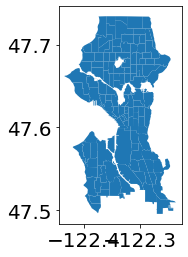

In [22]:
census_bounds_cleaned.plot()

We also need to get the centroids of the census tract data for the population data set.

<ipython-input-21-8d5059f3b47a>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_cent['geometry'] = census_cent['geometry'].centroid


<AxesSubplot:>

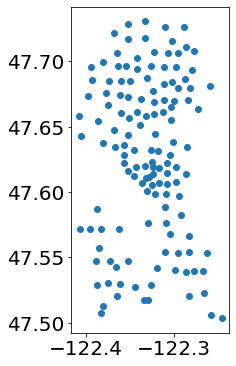

In [21]:
#Centroid points of census tracts
census_cent = census_bounds_cleaned.copy()

census_cent['geometry'] = census_cent['geometry'].centroid
census_cent.plot(figsize=(15,6))

## Narrow zip codes by census tracts
We do this to limit the zip code areas to only Seattle.

In [94]:
# Zip codes joined with census tracts
zips = gpd.sjoin(zipcodes_cleaned, census_bounds_cleaned, op='intersects')
zips_columns = ['ZIPCODE', 'NAME10', 'SHAPE_Area_left', 'geometry']
zips = zips[zips_columns]

<AxesSubplot:>

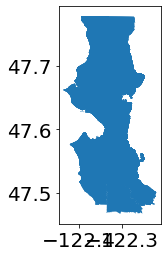

In [95]:
zips.plot()

In [25]:
zips.rename(columns = {'SHAPE_Area_left': 'SHAPE_Area'})

,ZIPCODE,NAME10,SHAPE_Area,geometry
34,98101,74.02,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6..."
35,98102,74.02,4.322189e+07,"POLYGON ((-122.31232 47.64705, -122.31321 47.6..."
77,98122,74.02,6.454818e+07,"POLYGON ((-122.32272 47.61931, -122.32282 47.6..."
34,98101,74.01,1.470012e+07,"POLYGON ((-122.32785 47.61850, -122.32791 47.6..."
35,98102,74.01,4.322189e+07,"POLYGON ((-122.31232 47.64705, -122.31321 47.6..."
...,...,...,...,...
90,98177,16.00,1.596729e+08,"POLYGON ((-122.35904 47.77776, -122.35937 47.7..."
90,98177,5.00,1.596729e+08,"POLYGON ((-122.35904 47.77776, -122.35937 47.7..."
91,98178,260.01,1.353505e+08,"POLYGON ((-122.21902 47.50057, -122.21914 47.5..."
99,98199,56.00,1.145346e+08,"MULTIPOLYGON (((-122.40912 47.67160, -122.4093..."


In [26]:
zips_sea = zips.dissolve(by='ZIPCODE')

<AxesSubplot:>

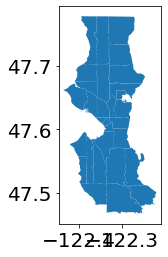

In [27]:
zips_sea.plot()

## Bike Rack data

In [28]:
# Loads bike rack data
racks_url = 'https://opendata.arcgis.com/datasets/f86c29ce743e47819e588c3d643ceb63_0.geojson'
r = gpd.read_file(racks_url)

In [29]:
# Creates a dataframe "racks" of bike rack locations and years installed
racks = r[['INSTALL_DATE', 'RACK_CAPACITY', 'geometry']]
racks = racks[racks.INSTALL_DATE.notnull()]
racks['Year'] = pd.DatetimeIndex(racks['INSTALL_DATE']).year
racks = racks.drop(columns='INSTALL_DATE')

In [30]:
racks.head()

,RACK_CAPACITY,geometry,Year
4,12,POINT (-122.31426 47.65824),2019
5,2,POINT (-122.33076 47.60690),2015
6,8,POINT (-122.33386 47.60394),2014
7,2,POINT (-122.34242 47.63076),2012
8,2,POINT (-122.31218 47.66483),2016


In [31]:
racks_half_filtered = racks[racks['Year'] >= 2007]

In [32]:
racks_filtered = racks_half_filtered[racks_half_filtered['Year'] <= 2018]

In [33]:
racks_filtered.head()

,RACK_CAPACITY,geometry,Year
5,2,POINT (-122.33076 47.60690),2015
6,8,POINT (-122.33386 47.60394),2014
7,2,POINT (-122.34242 47.63076),2012
8,2,POINT (-122.31218 47.66483),2016
10,2,POINT (-122.34957 47.65041),2008


In [34]:
racks_zips = gpd.sjoin(zips_sea, racks_filtered, op='contains')

In [35]:
racks_zips.reset_index(inplace=True)

In [36]:
racks_zips.head()

,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,RACK_CAPACITY,Year
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,2529,2,2016
1,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,2457,2,2014
2,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,2257,8,2014
3,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,630,2,2010
4,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,1934,14,2013


In [37]:
len(racks_zips)

1596

In [38]:
zips_racks = racks_zips.dissolve(by=["Year", "ZIPCODE"], aggfunc=sum)

In [39]:
zips_racks.reset_index(inplace=True)

In [40]:
zips_racks.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,RACK_CAPACITY
0,2007,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",592.16,1.176010e+08,15566,16
1,2007,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",148.04,8.644377e+07,4465,4
2,2007,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",360.00,1.152067e+09,17688,20
3,2007,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",252.00,6.326191e+07,4806,10
4,2007,98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",615.00,1.455532e+09,35219,34


In [159]:
len(zips_racks)

243

In [177]:
zips_racks_clean = zips_racks[['Year', 'ZIPCODE', 'RACK_CAPACITY']]

## Bike Lanes

In [41]:
#Bike lanes and walkways
df_SND = gpd.read_file('Street_Network_Database_SND.geojson')

In [42]:
lane_columns = ['SEGMENT_TY', 'SNDSEG_UPD', 'SHAPE_Leng', 'geometry']
bike_lane = df_SND[lane_columns]

In [43]:
bike_lane['Year'] = pd.DatetimeIndex(bike_lane['SNDSEG_UPD']).year
bike_lane.drop(columns='SNDSEG_UPD')

/home/spristash3/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,SEGMENT_TY,SHAPE_Leng,geometry,Year
0,1,291.426335,"LINESTRING (-122.32286 47.52981, -122.32287 47...",2007
1,1,431.467882,"LINESTRING (-122.32400 47.61848, -122.32401 47...",2007
2,1,162.446146,"LINESTRING (-122.29191 47.76490, -122.29126 47...",2004
3,6,79.522621,"LINESTRING (-122.30780 47.61410, -122.30748 47...",2004
4,1,643.835648,"LINESTRING (-122.38213 47.67455, -122.38474 47...",2012
...,...,...,...,...
34201,1,305.488287,"LINESTRING (-122.31417 47.67145, -122.31410 47...",2021
34202,1,97.898257,"LINESTRING (-122.34210 47.60772, -122.34250 47...",2021
34203,1,421.473404,"LINESTRING (-122.32610 47.46873, -122.32440 47...",2021
34204,1,238.008808,"LINESTRING (-122.32440 47.46874, -122.32344 47...",2021


In [44]:
#selects only data points with years after 2007 to match traffic data
bike_half_filtered = bike_lane[bike_lane['Year'] >= 2007]

In [45]:
#selects only data points with years before 2018 to match traffic data
bike_filtered = bike_half_filtered[bike_half_filtered['Year'] <= 2018]

In [46]:
#this data set contains bike lanes and walkways, this selects only bike lanes
bike_lanes = bike_filtered[bike_filtered['SEGMENT_TY']==6]

In [47]:
# # Joins zip codes with bike racks
zips_bikelane = gpd.sjoin(zips_sea, bike_lanes, op='intersects')

In [48]:
zips_bikelane.reset_index(inplace=True)

In [49]:
zips_bikelane.head()

,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,Year
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,33054,6,2018-10-10,348.181761,2018
1,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,19520,6,2011-02-24,37.022380,2011
2,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,19360,6,2011-02-24,48.332055,2011
3,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,19618,6,2011-02-24,155.004470,2011
4,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",45.00,1.440083e+08,29471,6,2015-10-16,175.772258,2015


In [50]:
zips_lanes = zips_bikelane.dissolve(by=['Year', 'ZIPCODE'], aggfunc=sum)

In [51]:
zips_lanes.reset_index(inplace=True)

In [52]:
zips_lanes.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng
0,2007,98109,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",148.02,1.327115e+08,35860,12,333.346820
1,2007,98112,"MULTIPOLYGON (((-122.31863 47.63049, -122.3186...",65.00,8.818645e+07,760,6,298.814978
2,2007,98118,"MULTIPOLYGON (((-122.29280 47.53008, -122.2924...",234.00,3.414372e+08,31739,12,462.728981
3,2007,98122,"POLYGON ((-122.32845 47.61473, -122.32802 47.6...",74.02,6.454818e+07,9308,6,179.593800
4,2008,98109,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",74.01,6.635577e+07,18299,6,240.982966


In [158]:
len(zips_lanes)

73

In [178]:
zips_lanes_clean = zips_lanes[['Year', 'ZIPCODE', "SHAPE_Leng"]]

In [179]:
zips_lanes_clean = zips_lanes_clean.rename(columns = {'SHAPE_Leng': "Lane_Length"})

## Walkways

Note: the walkways data is from the same dataset as the bike lanes, so we just need to select the proper category.

In [53]:
walks = bike_filtered[bike_filtered['SEGMENT_TY']==5]

In [54]:
walks.head()

,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,geometry,Year
17992,5,2008-04-09,465.983637,"LINESTRING (-122.38645 47.54191, -122.38646 47...",2008
18578,5,2018-08-07,205.825219,"LINESTRING (-122.39685 47.56481, -122.39687 47...",2018
18579,5,2018-08-07,477.994666,"LINESTRING (-122.39689 47.56250, -122.39690 47...",2018
26160,5,2018-08-07,256.086521,"LINESTRING (-122.37126 47.57126, -122.37129 47...",2018
26161,5,2018-08-07,231.884838,"LINESTRING (-122.37137 47.56987, -122.37139 47...",2018


In [55]:
# # Joins zip codes with bike racks
zips_walks = gpd.sjoin(zips_sea, walks, op='intersects')

In [56]:
zips_walks.reset_index(inplace=True)

In [57]:
zips_walks.head()

,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SNDSEG_UPD,SHAPE_Leng,Year
0,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,32045,5,2018-06-12,305.995367,2018
1,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,32050,5,2018-06-12,306.366108,2018
2,98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",41.00,9.703543e+07,27584,5,2018-07-20,219.509921,2018
3,98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",41.00,9.703543e+07,27580,5,2018-07-20,689.724771,2018
4,98106,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",114.02,1.482014e+08,27746,5,2015-03-27,666.636653,2015


In [58]:
zips_walkways = zips_walks.dissolve(by=['Year', 'ZIPCODE'], aggfunc=sum)

In [59]:
zips_walkways.reset_index(inplace=True)

In [60]:
zips_walkways.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng
0,2008,98136,"POLYGON ((-122.40199 47.55763, -122.40137 47.5...",106.00,6.319544e+07,17992,5,465.983637
1,2014,98117,"POLYGON ((-122.40987 47.67665, -122.40833 47.6...",35.00,1.073120e+08,27631,5,665.738612
2,2015,98106,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",114.02,1.482014e+08,27746,5,666.636653
3,2015,98121,"POLYGON ((-122.36110 47.61854, -122.36095 47.6...",81.00,1.225219e+07,28226,5,729.415860
4,2016,98119,"POLYGON ((-122.38986 47.63197, -122.38976 47.6...",80.01,7.607224e+07,29983,5,863.086371


In [157]:
len(zips_walkways)

16

In [180]:
zips_walkways_clean = zips_walkways[['Year', 'ZIPCODE', "SHAPE_Leng"]]

In [181]:
zips_walkways_clean = zips_walkways_clean.rename(columns = {'SHAPE_Leng': "Walkway_Length"})

## Populations

The population data is sorted by census tract, so to avoid double counting populations we will do a spatial join by centroids instead of across the two polygons.

In [81]:
pop_url_2010 = 'https://gisrevprxy.seattle.gov/arcgis/rest/services/CENSUS_EXT/CENSUS_2010_BASICS/MapServer/15/query?where=1%3D1&outFields=SHAPE,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID&outSR=4326&f=json'

In [186]:
pop_2010 = gpd.read_file(pop_url_2010)
pop_2010['geometry'] = census_cent['geometry']
pop_2010.head()

,GEOID10,NAME10,ACRES_TOTAL,Total_Population,OBJECTID,geometry
0,53033002500,25,243.219083,2802.0,1,POINT (-122.30228 47.68390)
1,53033002600,26,307.584420,4660.0,2,POINT (-122.31193 47.68275)
2,53033005600,56,737.511727,6382.0,3,POINT (-122.40574 47.64278)
3,53033006800,68,177.438771,2834.0,4,POINT (-122.35646 47.63603)
4,53033006000,60,324.567432,5150.0,5,POINT (-122.35286 47.64393)


<AxesSubplot:>

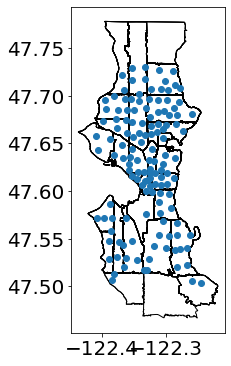

In [93]:
fig, ax = plt.subplots(figsize=(15,6))
zips.plot(ax=ax, facecolor='none',edgecolor='k')
pop_2010.plot(ax=ax)

<AxesSubplot:>

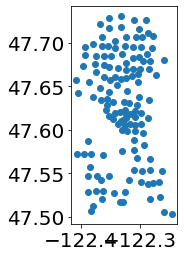

In [83]:
pop_2010.plot()

In [84]:
pop_2010.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [187]:
pop_zips = gpd.sjoin(zips_sea, pop_2010, op='contains')

In [188]:
pop_zips.head()

,geometry,NAME10_left,SHAPE_Area_left,index_right,GEOID10,NAME10_right,ACRES_TOTAL,Total_Population,OBJECTID
ZIPCODE,,,,,,,,,
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,65,53033008100,81,206.340307,4070.0,66
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,66,53033008200,82,90.611670,3280.0,67
98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",74.02,1.470012e+07,67,53033008300,83,58.672725,2505.0,68
98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,75,53033007401,74.01,64.092745,4115.0,76
98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",74.02,4.322189e+07,82,53033006100,61,276.424774,4796.0,83


<AxesSubplot:>

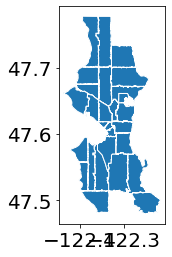

In [189]:
pop_zips.plot(edgecolor = 'white')

In [190]:
pop_zips.reset_index(inplace=True)

In [191]:
pop_zips = pop_zips[['ZIPCODE','geometry', 'Total_Population']]

In [192]:
pop_zips.head()

,ZIPCODE,geometry,Total_Population
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",4070.0
1,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",3280.0
2,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",2505.0
3,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",4115.0
4,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",4796.0


In [193]:
pop_zips_diss = pop_zips.dissolve(by='ZIPCODE', aggfunc='sum')

In [194]:
pop_zips_diss.reset_index(inplace=True)

In [195]:
pop_zips_diss.head()

,ZIPCODE,geometry,Total_Population
0,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",9855.0
1,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",12451.0
2,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",43659.0
3,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",9674.0
4,98105,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",44553.0


In [196]:
pop_zips_diss_clean = pop_zips_diss[['ZIPCODE', 'Total_Population']]

In [197]:
total_pop = pop_zips_diss_clean['Total_Population'].sum()
total_pop

608660.0

In [198]:
pop_zips_diss_clean['Pop_fraction'] = pop_zips_diss_clean['Total_Population']/total_pop
pop_zips_diss_clean.head()

,ZIPCODE,Total_Population,Pop_fraction
0,98101,9855.0,0.016191
1,98102,12451.0,0.020456
2,98103,43659.0,0.071730
3,98104,9674.0,0.015894
4,98105,44553.0,0.073199


In [199]:
years = list(range(2007, 2019))
years

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

In [200]:
populations = [585436, 591870, 598539, 608660, 622694, 635928, 653588, 670109, 687386, 709631, 728661, 742235]

In [201]:
pop_by_year = dict(zip(years, populations))
pop_by_year

{2007: 585436,
 2008: 591870,
 2009: 598539,
 2010: 608660,
 2011: 622694,
 2012: 635928,
 2013: 653588,
 2014: 670109,
 2015: 687386,
 2016: 709631,
 2017: 728661,
 2018: 742235}

In [202]:
def est_zip_pop(year, pop_zips_diss_clean, pop_by_year):
    pop_frac = pop_zips_diss_clean['Pop_fraction'].values
    year_pop = pop_by_year.get(year)
    pop_zip_year = pop_zips_diss_clean.copy()
    pop_zip_year['Total_Population'] = pop_frac*year_pop
    return pop_zip_year

In [204]:
pop_zip_2007 = est_zip_pop(2007, pop_zips_diss_clean, pop_by_year)
pop_zip_2007.head()

,ZIPCODE,Total_Population,Pop_fraction
0,98101,9478.973121,0.016191
1,98102,11975.920277,0.020456
2,98103,41993.149417,0.071730
3,98104,9304.879348,0.015894
4,98105,42853.037998,0.073199


In [205]:
total_pop_2007 = pop_zip_2007['Total_Population'].sum()
total_pop_2007

585435.9999999999

In [206]:
pop_zips_years = gpd.GeoDataFrame()
for year in years:
    pop_zip_year = est_zip_pop(year, pop_zips_diss_clean, pop_by_year)
    pop_zip_year['Year'] = year
    pop_zips_years = pop_zips_years.append(pop_zip_year)


In [207]:
pop_zips_years

,ZIPCODE,Total_Population,Pop_fraction,Year
0,98101,9478.973121,0.016191,2007
1,98102,11975.920277,0.020456,2007
2,98103,41993.149417,0.071730,2007
3,98104,9304.879348,0.015894,2007
4,98105,42853.037998,0.073199,2007
...,...,...,...,...
23,98146,7353.328706,0.009907,2018
24,98177,9771.512922,0.013165,2018
25,98178,8797.166382,0.011852,2018
26,98195,6958.224477,0.009375,2018


In [118]:
pop_zips_years.tail()

,ZIPCODE,geometry,Total_Population,Pop_fraction,Year
23,98146,"POLYGON ((-122.39570 47.51383, -122.39563 47.5...",7353.328706,0.009907,2018
24,98177,"POLYGON ((-122.39486 47.77797, -122.39449 47.7...",9771.512922,0.013165,2018
25,98178,"POLYGON ((-122.28336 47.50997, -122.28255 47.5...",8797.166382,0.011852,2018
26,98195,"POLYGON ((-122.31218 47.65338, -122.31215 47.6...",6958.224477,0.009375,2018
27,98199,"MULTIPOLYGON (((-122.43581 47.66206, -122.4355...",20884.429090,0.028137,2018


In [208]:
len(pop_zips_years)

336

In [209]:
pop_zips_years = pop_zips_years[['Year', 'ZIPCODE', 'Total_Population', 'Pop_fraction']]

# Merging all features into one dataset for model

In [217]:
a = pd.merge(pop_zips_years, zips_racks_clean, how='left', on= ['Year', 'ZIPCODE'])

In [218]:
a.head()

,Year,ZIPCODE,Total_Population,Pop_fraction,RACK_CAPACITY
0,2007,98101,9478.973121,0.016191,16.0
1,2007,98102,11975.920277,0.020456,4.0
2,2007,98103,41993.149417,0.071730,20.0
3,2007,98104,9304.879348,0.015894,10.0
4,2007,98105,42853.037998,0.073199,34.0


In [219]:
b = pd.merge(a, zips_lanes_clean, how='left', on= ['Year', 'ZIPCODE'])

In [220]:
all_data = pd.merge(b, zips_walkways_clean, how='left', on =['Year', 'ZIPCODE'])

In [221]:
len(all_data)

336

In [222]:
all_data.head()

,Year,ZIPCODE,Total_Population,Pop_fraction,RACK_CAPACITY,Lane_Length,Walkway_Length
0,2007,98101,9478.973121,0.016191,16.0,NaN,NaN
1,2007,98102,11975.920277,0.020456,4.0,NaN,NaN
2,2007,98103,41993.149417,0.071730,20.0,NaN,NaN
3,2007,98104,9304.879348,0.015894,10.0,NaN,NaN
4,2007,98105,42853.037998,0.073199,34.0,NaN,NaN


In [224]:
all_data_2007 = all_data.loc[all_data['Year'] == 2007]

In [227]:
len(all_data_2007)

28

In [231]:
for year in years:
    all_data_year = all_data.loc[all_data['Year'] == year]
    print(year, ':', all_data_year.isnull().sum())

2007 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY        9
Lane_Length         24
Walkway_Length      28
dtype: int64
2008 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY        6
Lane_Length         26
Walkway_Length      27
dtype: int64
2009 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY        5
Lane_Length         27
Walkway_Length      28
dtype: int64
2010 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY       11
Lane_Length         27
Walkway_Length      28
dtype: int64
2011 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction         0
RACK_CAPACITY       14
Lane_Length         10
Walkway_Length      28
dtype: int64
2012 : Year                 0
ZIPCODE              0
Total_Population     0
Pop_fraction       

Years with at least one instance of all 4 features: 2008, 2014 - 2018

For 2008:
* lanes has data for 98109 and 98126
* walks has 98136

For 2014: 
* lanes has data for 98105, 98112, 98126, 98144
* walks has 98117

For 2015: 
* lanes has data for 98103, 98105, 98106, 98108, 98109, 98112, 98116, 98117, 98119, 98126, 98144, 98146, 98145, 98199
* walks has 98106 and 98121
* __98106 is a match__

For 2016: 
* lanes has data for 98103, 98105, 98112, 98115
* walks has 98119, 98121, and and 98199

For 2017: 
* lanes has data for 98104, 98105, 98106, 98107, 98108, 98112, 98115, 98116, 98118, 98119, 98121, 98122, 98125, 98126, 98136, 98144
* walks has 98112, 98118, 98126, and 98144
* __98112, 98118, 98126, and 98144 is a match__

For 2018: 
* lanes has data for 98101, 98118, 98122, and 98126
* walks has 98104, 98105, 98107, 98116, and 98126
* __98126 is a match__

In [255]:
zips_lanes_2018 = zips_lanes_clean.loc[zips_lanes_clean['Year'] == 2018]

In [256]:
zips_lanes_2018

,Year,ZIPCODE,Lane_Length
69,2018,98101,348.181761
70,2018,98118,269.759130
71,2018,98122,134.256722
72,2018,98126,103.611745


In [257]:
zips_walks_2018 = zips_walkways_clean.loc[zips_walkways_clean['Year'] == 2018]

In [258]:
zips_walks_2018

,Year,ZIPCODE,Walkway_Length
11,2018,98104,612.361474
12,2018,98105,909.234692
13,2018,98107,195.281209
14,2018,98116,1319.979585
15,2018,98126,1422.466556


In [261]:
zips_racks_2017 = zips_racks_clean.loc[zips_racks_clean['Year'] == 2017]
zips_racks_2017

,Year,ZIPCODE,RACK_CAPACITY
205,2017,98101,6
206,2017,98102,22
207,2017,98103,20
208,2017,98104,102
209,2017,98106,24
210,2017,98107,28
211,2017,98108,6
212,2017,98109,16
213,2017,98112,2
214,2017,98115,2


In [259]:
zips_racks_2010 = zips_racks.loc[zips_racks['Year'] == 2010]

In [124]:
zips_racks_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,RACK_CAPACITY
65,2010,98101,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",148.04,2.940025e+07,2082,4
66,2010,98102,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",296.08,1.728875e+08,9258,8
67,2010,98103,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",315.00,1.008058e+09,14057,32
68,2010,98104,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,30,14
69,2010,98105,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",205.00,4.851772e+08,9872,22


In [125]:
zips_lanes_2010 = zips_lanes.loc[zips_lanes['Year'] == 2010]
zips_lanes_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng
7,2010,98109,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",74.01,6.635577e+07,18952,6,157.179735


In [126]:
zips_walkways_2010 = zips_walkways.loc[zips_walkways['Year'] == 2010]
zips_walkways_2010.head()

,Year,ZIPCODE,geometry,NAME10,SHAPE_Area_left,index_right,SEGMENT_TY,SHAPE_Leng


In [127]:
pops_zips_years_2010 = pop_zips_years.loc[pop_zips_years['Year'] == 2010]
pops_zips_years_2010.head()

,Year,ZIPCODE,Total_Population,Pop_fraction,geometry
0,2010,98101,9855.0,0.016191,"POLYGON ((-122.34598 47.60892, -122.34490 47.6..."
1,2010,98102,12451.0,0.020456,"POLYGON ((-122.33574 47.64203, -122.33108 47.6..."
2,2010,98103,43659.0,0.071730,"POLYGON ((-122.35808 47.69966, -122.35741 47.6..."
3,2010,98104,9674.0,0.015894,"POLYGON ((-122.34105 47.59627, -122.34031 47.5..."
4,2010,98105,44553.0,0.073199,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286..."


In [140]:
len(pops_zips_years_2010)

28

In [130]:
zips_racks_2010_pd = pd.DataFrame(zips_racks_2010)

In [131]:
pops_zips_years_2010_pd = pd.DataFrame(pops_zips_years_2010)

In [150]:
test = pd.merge(pops_zips_years_2010_pd, zips_racks_2010,  how ='left', on='ZIPCODE')

In [151]:
len(test)

28

In [152]:
test2 = pd.merge(test, zips_lanes_2010, how = 'left', on = 'ZIPCODE')

In [153]:
len(test2)

28

In [156]:
test2.head(10)

,Year_x,ZIPCODE,Total_Population,Pop_fraction,geometry_x,Year_y,geometry_y,NAME10_x,SHAPE_Area_left_x,index_right_x,RACK_CAPACITY,Year,geometry,NAME10_y,SHAPE_Area_left_y,index_right_y,SEGMENT_TY,SHAPE_Leng
0,2010,98101,9855.0,0.016191,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",2010.0,"POLYGON ((-122.34598 47.60892, -122.34490 47.6...",148.04,2.940025e+07,2082.0,4.0,NaN,None,NaN,NaN,NaN,NaN,NaN
1,2010,98102,12451.0,0.020456,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",2010.0,"POLYGON ((-122.33574 47.64203, -122.33108 47.6...",296.08,1.728875e+08,9258.0,8.0,NaN,None,NaN,NaN,NaN,NaN,NaN
2,2010,98103,43659.0,0.071730,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",2010.0,"POLYGON ((-122.35808 47.69966, -122.35741 47.6...",315.00,1.008058e+09,14057.0,32.0,NaN,None,NaN,NaN,NaN,NaN,NaN
3,2010,98104,9674.0,0.015894,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",2010.0,"POLYGON ((-122.34105 47.59627, -122.34031 47.5...",84.00,2.108730e+07,30.0,14.0,NaN,None,NaN,NaN,NaN,NaN,NaN
4,2010,98105,44553.0,0.073199,"MULTIPOLYGON (((-122.32859 47.66649, -122.3286...",2010.0,"MULTIPOLYGON (((-122.32859 47.66646, -122.3285...",205.00,4.851772e+08,9872.0,22.0,NaN,None,NaN,NaN,NaN,NaN,NaN
5,2010,98106,23568.0,0.038721,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",2010.0,"POLYGON ((-122.37057 47.56924, -122.37056 47.5...",114.02,1.482014e+08,1142.0,2.0,NaN,None,NaN,NaN,NaN,NaN,NaN
6,2010,98107,22263.0,0.036577,"MULTIPOLYGON (((-122.40896 47.67540, -122.4072...",2010.0,"MULTIPOLYGON (((-122.40896 47.67540, -122.4072...",96.00,1.309021e+08,3303.0,16.0,NaN,None,NaN,NaN,NaN,NaN,NaN
7,2010,98108,22590.0,0.037114,"POLYGON ((-122.33799 47.53397, -122.33787 47.5...",2010.0,"POLYGON ((-122.33799 47.53397, -122.33787 47.5...",465.00,1.075290e+09,10624.0,10.0,NaN,None,NaN,NaN,NaN,NaN,NaN
8,2010,98109,31473.0,0.051709,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",NaN,None,NaN,NaN,NaN,NaN,2010.0,"POLYGON ((-122.35819 47.64769, -122.35810 47.6...",74.01,6.635577e+07,18952.0,6.0,157.179735
9,2010,98112,24148.0,0.039674,"MULTIPOLYGON (((-122.31863 47.63041, -122.3186...",2010.0,"MULTIPOLYGON (((-122.31863 47.63049, -122.3186...",130.00,1.763729e+08,713.0,4.0,NaN,None,NaN,NaN,NaN,NaN,NaN
